In [ ]:
# Train/Val/Test 데이터셋 분류

import os
import shutil

dataroot = 'dataset'
classes_list = os.listdir(dataroot)

base_dir = 'splitted'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
val_dir = os.path.join(base_dir, 'val')
os.makedirs(val_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

for class_ in classes_list :
    os.makedirs(os.path.join(train_dir, class_))
    os.makedirs(os.path.join(val_dir, class_))
    os.makedirs(os.path.join(test_dir, class_))

In [17]:
import math

for class_ in classes_list :
    path = os.path.join(dataroot, class_)
    fnames = os.listdir(path)
    
    train_size = math.floor(len(fnames)*0.6)
    validation_size = math.floor(len(fnames)*0.2)
    test_size = math.floor(len(fnames)*0.2)

    train_fnames = fnames[:train_size]
    print('Train size : ' + str(len(train_fnames)) )

    for fname in train_fnames :
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir,class_), fname)
        shutil.copyfile(src,dst)

    validation_fnames = fnames[train_size:(validation_size + train_size)]
    print('Validation size : ' + str(len(validation_fnames)) )

    for fname in validation_fnames :
        scr = os.path.join(path,fname)
        dst = os.path.join(os.path.join(val_dir, class_), fname)
        shutil.copyfile(src, dst)

    test_fnames = fnames[(train_size + validation_size):(validation_size + train_size + test_size)]
    print('Test size : ' + str(len(test_fnames)) )

    for fname in test_fnames :
        scr = os.path.join(path,fname)
        dst = os.path.join(os.path.join(test_dir, class_), fname)
        shutil.copyfile(src, dst)

Train size : 378
Validation size : 126
Test size : 126
Train size : 372
Validation size : 124
Test size : 124
Train size : 165
Validation size : 55
Test size : 55
Train size : 987
Validation size : 329
Test size : 329
Train size : 512
Validation size : 170
Test size : 170
Train size : 631
Validation size : 210
Test size : 210
Train size : 307
Validation size : 102
Test size : 102
Train size : 715
Validation size : 238
Test size : 238
Train size : 697
Validation size : 232
Test size : 232
Train size : 591
Validation size : 197
Test size : 197
Train size : 708
Validation size : 236
Test size : 236
Train size : 829
Validation size : 276
Test size : 276
Train size : 253
Validation size : 84
Test size : 84
Train size : 645
Validation size : 215
Test size : 215
Train size : 1378
Validation size : 459
Test size : 459
Train size : 216
Validation size : 72
Test size : 72
Train size : 598
Validation size : 199
Test size : 199
Train size : 886
Validation size : 295
Test size : 295
Train size : 60

In [10]:
import torch

USE_CUDA = torch.cuda.is_available()
DIVECE = torch.device('cuda' if USE_CUDA else 'cpu')

BATCH_SIZE = 256
EPOCH = 30

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

transform_base = transforms.Compose(
    [transforms.Resize((64,64)),
    transforms.ToTensor()]
)
# train_dataset.class_to_idx으로 0번이 어떤 클래스고 이런거 확인 가능함
train_dataset = ImageFolder(root = 'splitted/train', transform = transform_base)
val_dataset = ImageFolder(root = 'splitted/val', transform = transform_base)

from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module) :
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,32,3, padding = 1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,3, padding = 1)
        self.conv3 = nn.Conv2d(64,64,3, padding = 1)
        self.fc1 = nn.Linear(4096, 512)
        self.fc2 = nn.Linear(512,33)
    
    def forward(self,x) :
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = x.view(-1,4096)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


In [31]:
model_base = Net().to(DIVECE)
optimizer = optim.Adam(model_base.parameters(), lr = 0.001)

In [32]:
def train(model, train_loader, optimizer) :
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader) :
        # print(target) 1, 3, 5, 6 이런식으로 labeling이 됨 
        data, target = data.to(DIVECE), target.to(DIVECE)
        optimizer.zero_grad()
        output = model(data)
        # CE에는 Softmax가 CE 안에 포함되어 있어서 Softmax를 굳이 쓰지 않아도 괜찮음.
        # 하지만 BCE에서는 CE만 구현되어 있기 때문에 Activation Function이 반드시 필요함
        # 만약에 BCE에서 Sigmoid를 사용하고 CE 하고 싶으면, BCEWithLogitsLoss를 사용하면 자체에 Sigmoid까지 포함하고 있음
        # print(output.size()) # 256(bs) x 33 (batch, class)
        # print(target.size()) # 256 (batch, )
        # BCELoss에서는 output : (batch,)  // target : (batch,) 
        loss =F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

def evaluate(model, test_loader) :
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad() :
        for data, target in test_loader :
            data, target = data.to(DIVECE), target.to(DIVECE)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            pred = output.max(1, keepdim=True)[1]
            # print(output.max(1, keepdim=True))
            # [값이 가장 큰 것 max값 한 개 뽑아(Softmax 통과 후 확률값), indices = 가장 큰 값의 인덱스 반환)
            # output.max(1, keepdim=True)[1] - > 확률값이 가장 큰 것의 인덱스를 의미함
            # target.view_as(pred)가 의미하는 것은 target을 pred랑 같은 shape로 만들어라 라는 의미
            # 그리고 pred.eq(~)는 pred와 ~가 같으면 1 아니면 0으로 반환함
            # 그래서, sum() 함수가 있기 때문에 같은 애들의 개수를 셈
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.0 * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [33]:
import time
import copy

def train_baseline(model, train_loader, val_loader, optimizer, num_epochs = 30) :
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(1,num_epochs + 1) :
        since = time.time()
        train(model, train_loader, optimizer)
        train_loss, train_acc = evaluate(model, train_loader)
        val_loss, val_acc = evaluate(model, val_loader)

        if val_acc > best_acc :
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('------epoch {}------'.format(epoch))
        print('train_loss : {:4f}, train_accuracy : {:.2f}%'.format(train_loss, train_acc))
        print('val_loss : {:4f}, val_accuracy : {:.2f}%'.format(val_loss, val_acc))
    
    model.load_state_dict(best_model_wts)
    return model


In [34]:
base = train_baseline(model_base, train_loader, val_loader, optimizer, EPOCH)
torch.save(base,'baseline.pt')

------epoch 1------
train_loss : 1.632790, train_accuracy : 53.57%
val_loss : 1.370508, val_accuracy : 61.60%
------epoch 2------
train_loss : 0.978223, train_accuracy : 71.96%
val_loss : 0.740906, val_accuracy : 81.40%
------epoch 3------
train_loss : 0.689418, train_accuracy : 78.78%
val_loss : 0.524913, val_accuracy : 88.35%
------epoch 4------
train_loss : 0.541626, train_accuracy : 83.15%
val_loss : 0.334062, val_accuracy : 89.27%
------epoch 5------
train_loss : 0.474510, train_accuracy : 85.51%
val_loss : 0.285801, val_accuracy : 92.70%
------epoch 6------
train_loss : 0.417308, train_accuracy : 87.36%
val_loss : 0.295315, val_accuracy : 94.76%
------epoch 7------
train_loss : 0.345082, train_accuracy : 89.48%
val_loss : 0.176796, val_accuracy : 98.72%
------epoch 8------
train_loss : 0.307142, train_accuracy : 90.53%
val_loss : 0.241873, val_accuracy : 93.85%
------epoch 9------
train_loss : 0.269429, train_accuracy : 91.95%
val_loss : 0.152119, val_accuracy : 95.12%
------epoc

test loss : 0.02367668410597374
test accuracy : 100.0


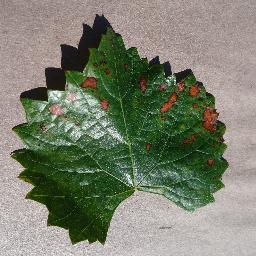

real class : Grape___Esca_(Black_Measles)
pred clss : Grape___Esca_(Black_Measles)


In [47]:
# Inference
from PIL import Image

test_dataset = ImageFolder(root = 'splitted/test', transform = transform_base)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

test_loss, test_accuracy = evaluate(base, test_loader)
print('test loss : ' + str(test_loss))
print('test accuracy : ' + str(test_accuracy))

image = Image.open('splitted/test/Grape___Esca_(Black_Measles)/image (80).JPG')
display(image)
print('real class : Grape___Esca_(Black_Measles)')

image = transform_base(image)
image = image.reshape(1,3,64,64)
image = image.cuda()

pred_prob = model_base(image)
pred = pred_prob.max(1, keepdim=True)[1]

cls_dict = train_dataset.class_to_idx
reverse_cls = {v:k for k,v in cls_dict.items()}
print('pred clss : ' + reverse_cls[pred.item()])


In [42]:
cls_dict

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Cherry___Powdery_mildew': 4,
 'Cherry___healthy': 5,
 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 6,
 'Corn___Common_rust': 7,
 'Corn___Northern_Leaf_Blight': 8,
 'Corn___healthy': 9,
 'Grape___Black_rot': 10,
 'Grape___Esca_(Black_Measles)': 11,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 12,
 'Grape___healthy': 13,
 'Peach___Bacterial_spot': 14,
 'Peach___healthy': 15,
 'Pepper,_bell___Bacterial_spot': 16,
 'Pepper,_bell___healthy': 17,
 'Potato___Early_blight': 18,
 'Potato___Late_blight': 19,
 'Potato___healthy': 20,
 'Strawberry___Leaf_scorch': 21,
 'Strawberry___healthy': 22,
 'Tomato___Bacterial_spot': 23,
 'Tomato___Early_blight': 24,
 'Tomato___Late_blight': 25,
 'Tomato___Leaf_Mold': 26,
 'Tomato___Septoria_leaf_spot': 27,
 'Tomato___Spider_mites Two-spotted_spider_mite': 28,
 'Tomato___Target_Spot': 29,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 30,
 'Tomato___Tom